In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 忽略警告
warnings.filterwarnings("ignore", category=FutureWarning)

# 读取市场信息数据
def load_market_info(info_folder):
    market_info = {}
    for year in range(2014, 2025):
        file_name = f'hs300stocks_{year}.csv'
        file_path = os.path.join(info_folder, file_name)
        if os.path.isfile(file_path):
            data = pd.read_csv(file_path)
            market_info[f'year_{year}'] = data
        else:
            print(f'Warning: File {file_path} does not exist.')
    return market_info

# 读取市场数据
def load_market_data(data_folder):
    market_data = {}
    for year in range(2014, 2025):
        file_name = f'hs300stocks_kdata_{year}.csv'
        file_path = os.path.join(data_folder, file_name)
        if os.path.isfile(file_path):
            data = pd.read_csv(file_path)
            market_data[f'year_{year}'] = data
        else:
            print(f'Warning: File {file_path} does not exist.')
    return market_data

# 获取沪深300市场数据
def get_hs300_data(market_data):
    combined_data = pd.concat(market_data.values(), ignore_index=True)
    
    # 确保时间列存在并转换为日期格式
    if 'date' in combined_data.columns:
        combined_data['time'] = pd.to_datetime(combined_data['date'], format='%Y-%m-%d', errors='coerce')
    elif 'time' in combined_data.columns:
        combined_data['time'] = pd.to_datetime(combined_data['time'], errors='coerce')
    else:
        raise KeyError("No 'date' or 'time' column found in the market data.")
    
    combined_data.sort_values('time', inplace=True)  # 按时间排序
    return combined_data

In [2]:
# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 取LSTM最后一个时间步的输出
        return out

# 计算市场波动率、最大回撤和夏普指数
def calculate_metrics(prices):
    returns = np.log(prices / prices.shift(1)).dropna()
    volatility = returns.std() * np.sqrt(252)  # 年化波动率
    max_drawdown = (prices / prices.cummax()).min() - 1  # 最大回撤
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)  # 年化夏普比率
    return volatility, max_drawdown, sharpe_ratio

# 设置参数
start_date = '2014-01-01'
end_date = '2024-10-31'
time_step = 60       # 调整时间步长
train_ratio = 0.8
input_size = 1
hidden_size = 64      # 调大hidden_size
num_layers = 2        # 增加LSTM层数
output_size = 3       # 预测三个指标
num_epochs = 100      # 增加训练轮数
learning_rate = 0.001 # 调整学习率

# 加载市场信息和数据
info_folder = 'StockData/market_info'
data_folder = 'StockData/market_data'
market_info = load_market_info(info_folder)
market_data = load_market_data(data_folder)

# 获取沪深300市场数据
hs300_data = get_hs300_data(market_data)

# 选择某只股票进行预测，例如选择某个特定的股票代码
stock_code = 'szse.000002'  # 选择万科A作为示例
stock_data = hs300_data[hs300_data['code'] == stock_code][['time', 'close']]
stock_data.set_index('time', inplace=True)

# 计算历史价格的波动率、最大回撤和夏普指数
volatility, max_drawdown, sharpe_ratio = calculate_metrics(stock_data['close'])

# 使用收盘价
df_close = stock_data[['close']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_close)

X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio, shuffle=False)

# 转换为PyTorch张量
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).view(-1, output_size)  # 适应输出维度
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).view(-1, output_size)

# 定义模型、损失函数和优化器
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()  # 使用均方误差损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# 训练模型
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 预测
model.eval()
train_predict = model(X_test)
train_predict = train_predict.detach().numpy()

# 还原预测值
train_predict = scaler.inverse_transform(train_predict)

NameError: name 'create_dataset' is not defined

X shape: (2435, 60, 7), y shape: (2435, 3)
Epoch [10/200], Loss: 1.3768
Epoch [20/200], Loss: 0.9309
Epoch [30/200], Loss: 0.8421
Epoch [40/200], Loss: 0.6853
Epoch [50/200], Loss: 0.6196
Epoch [60/200], Loss: 0.5857
Epoch [70/200], Loss: 0.5623
Epoch [80/200], Loss: 0.5661
Epoch [90/200], Loss: 0.5231
Epoch [100/200], Loss: 0.5084
Epoch [110/200], Loss: 0.4685
Epoch [120/200], Loss: 0.4715
Epoch [130/200], Loss: 0.4016
Epoch [140/200], Loss: 0.2935
Epoch [150/200], Loss: 0.3063
Epoch [160/200], Loss: 0.1915
Epoch [170/200], Loss: 0.1532
Epoch [180/200], Loss: 0.1310
Epoch [190/200], Loss: 0.1165
Epoch [200/200], Loss: 0.1055


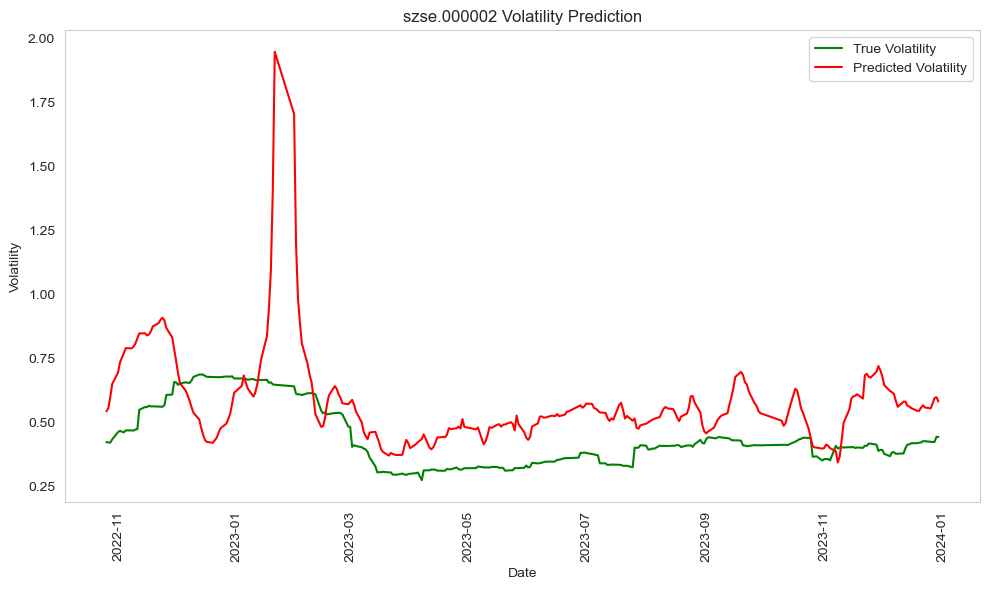

In [3]:
import pandas as pd
import os
import torch
import torch.nn as nn
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 忽略警告
warnings.filterwarnings("ignore", category=FutureWarning)

# 读取市场信息数据
def load_market_info(info_folder):
    market_info = {}
    for year in range(2014, 2025):
        file_name = f'hs300stocks_{year}.csv'
        file_path = os.path.join(info_folder, file_name)
        if os.path.isfile(file_path):
            data = pd.read_csv(file_path)
            market_info[f'year_{year}'] = data
        else:
            print(f'Warning: File {file_path} does not exist.')
    return market_info

# 读取市场数据
def load_market_data(data_folder):
    market_data = {}
    for year in range(2014, 2025):
        file_name = f'hs300stocks_kdata_{year}.csv'
        file_path = os.path.join(data_folder, file_name)
        if os.path.isfile(file_path):
            data = pd.read_csv(file_path)
            market_data[f'year_{year}'] = data
        else:
            print(f'Warning: File {file_path} does not exist.')
    return market_data

# 获取沪深300市场数据
def get_hs300_data(market_data):
    combined_data = pd.concat(market_data.values(), ignore_index=True)
    
    if 'date' in combined_data.columns:
        combined_data['time'] = pd.to_datetime(combined_data['date'], format='%Y-%m-%d', errors='coerce')
    elif 'time' in combined_data.columns:
        combined_data['time'] = pd.to_datetime(combined_data['time'], errors='coerce')
    else:
        raise KeyError("No 'date' or 'time' column found in the market data.")
    
    combined_data.sort_values('time', inplace=True)  # 按时间排序
    return combined_data

# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 取LSTM最后一个时间步的输出
        return out

# 生成训练数据
def create_dataset(data, technical_indicators, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X_data = data[i:(i + time_step), :]  # 使用价格数据和技术指标
        X_tech = technical_indicators[i:(i + time_step), :]
        X.append(np.hstack((X_data, X_tech)))  # 拼接价格数据和技术指标
        # 计算波动率、最大回撤和夏普比率
        prices = data[i:(i + time_step + 1), 0]  # 取当前时间步及后续时间步的收盘价
        volatility, max_drawdown, sharpe_ratio = calculate_metrics(prices)
        y.append([volatility, max_drawdown, sharpe_ratio])
    return np.array(X), np.array(y)

# 计算市场波动率、最大回撤和夏普指数
def calculate_metrics(prices):
    # 确保传入的是 Pandas Series 类型
    if isinstance(prices, np.ndarray):
        prices = pd.Series(prices)  # 转换为 Pandas Series
    # 处理价格为0或负数的情况
    prices = prices[prices > 0]  # 去除价格为0或负数的行
    if len(prices) < 2:
        return 0, 0, 0  # 若价格数据不足以计算，则返回0值
    # 计算收益率
    returns = np.log(prices / prices.shift(1)).dropna()
    # 年化波动率
    volatility = returns.std() * np.sqrt(252)
    # 计算最大回撤
    max_drawdown = (prices / prices.cummax()).min() - 1
    # 年化夏普比率
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
    return volatility, max_drawdown, sharpe_ratio


# 设置参数
start_date = '2014-01-01'
end_date = '2024-10-31'
time_step = 60       # 调整时间步长
train_ratio = 0.8
input_size = 7       # 修改为7，因为我们使用了4个价格数据特征和3个技术指标特征
hidden_size = 128    # 增加隐藏层单元数
num_layers = 3       # 增加LSTM层数
output_size = 3      # 预测三个指标
num_epochs = 200     # 增加训练轮数
learning_rate = 0.001 # 调整学习率

# 加载市场信息和数据
info_folder = 'StockData/market_info'
data_folder = 'StockData/market_data'
market_info = load_market_info(info_folder)
market_data = load_market_data(data_folder)

# 获取沪深300市场数据
hs300_data = get_hs300_data(market_data)

# 选择某只股票进行预测，例如选择某个特定的股票代码
stock_code = 'szse.000002'  # 选择万科A作为示例
stock_data = hs300_data[hs300_data['code'] == stock_code][['time', 'close', 'volume', 'high', 'low']]
stock_data.set_index('time', inplace=True)

# 计算技术指标
stock_data['returns'] = np.log(stock_data['close'] / stock_data['close'].shift(1)).fillna(0)
stock_data['rsi'] = stock_data['close'].rolling(14).apply(lambda prices: 100 - 100 / (1 + np.mean(np.maximum(0, prices - prices.shift(1))) / np.mean(np.abs(prices - prices.shift(1))))).fillna(0)
stock_data['macd'] = stock_data['close'].ewm(span=12, adjust=False).mean() - stock_data['close'].ewm(span=26, adjust=False).mean()
technical_indicators = stock_data[['returns', 'rsi', 'macd']].values

# 使用收盘价、成交量、最高价和最低价作为输入
df_input = stock_data[['close', 'volume', 'high', 'low']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_input)

# 生成训练数据集
X, y = create_dataset(scaled_data, technical_indicators, time_step)
print(f"X shape: {X.shape}, y shape: {y.shape}")  # 输出数据形状检查

X = X.reshape(X.shape[0], X.shape[1], X.shape[2])  # 确保X的形状正确

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio, shuffle=False)

# 转换为PyTorch张量
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)  # 适应输出维度
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

# 定义模型、损失函数和优化器
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()  # 使用均方误差损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# 训练模型
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 预测
model.eval()
train_predict = model(X_test)
train_predict = train_predict.detach().numpy()

# 绘制结果
plt.figure(figsize=(16, 10))
plt.plot(stock_data.index[-len(y_test):], y_test[:, 0], label='True Volatility', color='green')
plt.plot(stock_data.index[-len(y_test):], train_predict[:, 0], label='Predicted Volatility', color='red')
plt.title(f'{stock_code} Volatility Prediction')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xticks(rotation=90)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# 保存预测结果到CSV文件
predictions_df = pd.DataFrame(train_predict, columns=['Predicted_Volatility', 'Predicted_Max_Drawdown', 'Predicted_Sharpe_Ratio'])
predictions_df.to_csv(f'{stock_code}_predictions.csv', index=False)